## Project 3: Soccer Trades Analysis
#### Team 2: Brandon Tzou, Geon Kim, Stephen Lee, Vikram Magal

In [1]:
import numpy as np
import pandas as pd
import neo4j
import glob
import os
from fuzzywuzzy import fuzz
import re
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Read in and combine transfer data to create a dataframe called 'transfers'

transfers_fnames = {
    'German Bundesliga':'1-bundesliga',
    'French Ligue 1':'ligue-1',
    'English Premier League':'premier-league',
    'Spanish La Liga':'primera-division',
    'Italian Serie A':'serie-a'
}

transfers = pd.DataFrame()

for key, value in transfers_fnames.items():
    tdata = pd.read_csv(f'../data/{value}.csv')
    tdata['league_name'] = key
    transfers = pd.concat([tdata, transfers])

# Filter out any transfer without a public fee
transfers = transfers[
    (transfers['fee'] != '?') &
    (transfers['fee'] != '-') &
    (transfers['fee'].notna()) &
    (transfers['fee'] != 'free transfer') &
    (transfers['fee'] != 'draft') &
    (~transfers['fee'].astype(str).str.lower().str.contains('loan'))
]

# Turn fee column into a numeric by either multiplying by 1,000,000 or 1,000
transfers['fee_num'] = [float(x.strip('€').replace('m',''))*1000000 if 'm' in x else float(x.strip('€').replace('Th.',''))*1000 for x in transfers['fee']]
print("run correctly")

transfers=transfers[transfers['season'].isin({'2014/2015', '2015/2016', '2016/2017',
       '2017/2018', '2018/2019', '2019/2020', '2020/2021', '2021/2022'})]

run correctly


In [3]:
# Read in and combine league points data to create a dataframe called 'league_points'

league_fnames = {
    'Bundesliga': 'German Bundesliga', 
    'Ligue 1': 'French Ligue 1', 
    'Premier League': 'English Premier League', 
    'La Liga': 'Spanish La Liga', 
    'Serie A': 'Italian Serie A'
}

league_points = pd.DataFrame()

data_files = glob.glob('../data/League Stats/*.csv')
lpoint_files = [l for l in data_files if 'Champions' not in l and not str(l[0]).isdigit()]  # Filter out Champions League datasets

for fpath in lpoint_files:
    ldata = pd.read_csv(fpath)
    parts = fpath.split('_')

    if len(parts) >= 4:
        # Handle Bundesliga (single-word) vs other (two-word) league names
        if parts[2] == 'Bundesliga':
            league_key = parts[2]
        else:
            league_key = parts[2] + ' ' + parts[3]

        league_name = league_fnames.get(league_key, 'Unknown')
        ldata['league_name'] = league_name
        ldata['season'] = parts[0][-4:] + '/' + parts[1]
        league_points = pd.concat([ldata, league_points])
        print(f"O Loaded: {fpath} → {league_name}")
    else:
        print(f"X Skipped: {fpath} (unexpected filename format)")

# Drop columns not needed for success metric
league_points = league_points.drop(columns=['xG','xGA','xGD','xGD/90'])

### Calculate Success Metric:

# For all leagues other than Bundesliga
league_success_ranks_a = {
    1: 8,
    2: 6,
    3: 5,
    (4, 5): 3,
    (6, 10): 1,
    (11, 17): 0,
    (18, 20): -2
}

# For Bundesliga
league_success_ranks_b = {
    1: 8,
    2: 6,
    3: 5,
    (4, 5): 3,
    (6, 10): 1,
    (11, 15): 0,
    (16, 18): -2
}

def get_success_score(row):
    rank = row["Rk"]
    league = row["league_name"]

    success_ranks = league_success_ranks_b if league == "German Bundesliga" else league_success_ranks_a

    if rank in success_ranks:
        return success_ranks[rank]

    for key in success_ranks:
        if isinstance(key, tuple): 
            low, high = key
            if low <= rank <= high:
                return success_ranks[key]

league_points['success'] = league_points.apply(get_success_score, axis=1)

print("O All done.")


O Loaded: ../data/League Stats/2014_2015_Bundesliga_Stats.csv → German Bundesliga
O Loaded: ../data/League Stats/2014_2015_La_Liga_Stats.csv → Spanish La Liga
O Loaded: ../data/League Stats/2014_2015_Ligue_1_Stats.csv → French Ligue 1
O Loaded: ../data/League Stats/2014_2015_Premier_League_Stats.csv → English Premier League
O Loaded: ../data/League Stats/2014_2015_Serie_A_Stats.csv → Italian Serie A
O Loaded: ../data/League Stats/2015_2016_Bundesliga_Stats.csv → German Bundesliga
O Loaded: ../data/League Stats/2015_2016_La_Liga_Stats.csv → Spanish La Liga
O Loaded: ../data/League Stats/2015_2016_Ligue_1_Stats.csv → French Ligue 1
O Loaded: ../data/League Stats/2015_2016_Premier_League_Stats.csv → English Premier League
O Loaded: ../data/League Stats/2015_2016_Serie_A_Stats.csv → Italian Serie A
O Loaded: ../data/League Stats/2016_2017_Bundesliga_Stats.csv → German Bundesliga
O Loaded: ../data/League Stats/2016_2017_La_Liga_Stats.csv → Spanish La Liga
O Loaded: ../data/League Stats/2016

In [4]:
# Read in and combine Champions League data into a dataframe called 'cl_rankings'

cl_rankings = pd.DataFrame()

cl_files = glob.glob('../data/League Stats/*Champions_League*')

for fpath in cl_files:
    try:
        cldata = pd.read_csv(fpath)
        parts = fpath.split('_')
        
        if len(parts) >= 2:
            season_str = parts[0][-4:] + '/' + parts[1]
            cldata['season'] = season_str
            cl_rankings = pd.concat([cldata, cl_rankings])
            print(f"O Loaded: {fpath} → season: {season_str}")
        else:
            print(f"X Skipped (filename format issue): {fpath}")
    except Exception as e:
        print(f"XXXX Error loading {fpath}: {e}")

# Define success mapping for Champions League
cl_success_ranks = {
    "1": 10,
    "2": 7,
    "SF": 4,
    "QF": 3,
    "R16": 2,
    "GR": 1
}

# Map Rk to success scores
cl_rankings['success'] = cl_rankings['Rk'].map(cl_success_ranks)

print("O Champions League data processed.")


O Loaded: ../data/League Stats/2014_2015_Champions_League_Stats.csv → season: 2014/2015
O Loaded: ../data/League Stats/2015_2016_Champions_League_Stats.csv → season: 2015/2016
O Loaded: ../data/League Stats/2016_2017_Champions_League_Stats.csv → season: 2016/2017
O Loaded: ../data/League Stats/2017_2018_Champions_League_Stats.csv → season: 2017/2018
O Loaded: ../data/League Stats/2018_2019_Champions_League_Stats.csv → season: 2018/2019
O Loaded: ../data/League Stats/2019_2020_Champions_League_Stats.csv → season: 2019/2020
O Loaded: ../data/League Stats/2020_2021_Champions_League_Stats.csv → season: 2020/2021
O Loaded: ../data/League Stats/2021_2022_Champions_League_Stats.csv → season: 2021/2022
O Loaded: ../data/League Stats/2022_2023_Champions_League_Stats.csv → season: 2022/2023
O Loaded: ../data/League Stats/2023_2024_Champions_League_Stats.csv → season: 2023/2024
O Champions League data processed.


In [5]:
cl_rankings.head(20)

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,xG,xGA,xGD,xGD/90,Attendance,Top Team Scorer,Goalkeeper,Notes,season,success
0,1,Real Madrid,13,9,4,0,28,15,13,31,25.1,17.5,7.6,0.59,"72,777",Vinicius Júnior-6,Andriy Lunin,NaN,2023/2024,10.0
1,2,Dortmund,13,7,3,3,17,11,6,24,17.2,23.6,-6.4,-0.49,"82,057",Niclas Füllkrug-3,Gregor Kobel,NaN,2023/2024,7.0
2,SF,Bayern Munich,12,7,3,2,21,13,8,24,19.0,15.0,4.0,0.33,"75,000",Harry Kane-8,Manuel Neuer,NaN,2023/2024,4.0
3,SF,Paris S-G,12,5,2,5,19,15,4,17,24.3,13.3,11.0,0.91,"46,686",Kylian Mbappé-8,Gianluigi Donnarumma,NaN,2023/2024,4.0
4,QF,Manchester City,10,8,2,0,28,13,15,26,24.6,6.9,17.7,1.77,"51,298",Erling Haaland-6,Ederson,NaN,2023/2024,3.0
5,QF,Atlético Madrid,10,6,2,2,23,13,10,20,16.7,12.7,3.9,0.39,"64,803",Antoine Griezmann-6,Jan Oblak,NaN,2023/2024,3.0
6,QF,Barcelona,10,6,1,3,20,14,6,19,16.9,11.3,5.6,0.56,"45,308","Raphinha,Robert Lewandowski... -3",Marc-André ter Stegen,NaN,2023/2024,3.0
7,QF,Arsenal,10,5,2,3,19,8,11,17,13.4,8.5,4.9,0.49,"59,870","Leandro Trossard,Gabriel Jesus... -4",David Raya,NaN,2023/2024,3.0
8,R16,Porto,8,5,0,3,16,9,7,15,11.4,7.7,3.7,0.46,"47,944",Galeno-5,Diogo Costa,NaN,2023/2024,2.0
9,R16,Inter,8,4,3,1,10,7,3,15,16.2,8.6,7.6,0.94,"70,279","Alexis Sánchez,Marko Arnautović... -2",Yann Sommer,NaN,2023/2024,2.0


In [6]:
# Remove youth teams from the transfers dataset

invalid_teams = ['U17', 'U18', 'U19', 'U20', 'Youth', 'youth']

transfers = transfers[~transfers['club_name'].str.contains('|'.join(invalid_teams))]


In [7]:
def normalize(name):
    name = name.lower()
    name = re.sub(r'\b(fc|sc|afc|cf|club|the)\b', '', name)
    name = re.sub(r'[^\w\s]', '', name)
    name = re.sub(r'\s+', ' ', name)
    return name.strip()

In [8]:
cache_path = "../data/transfers_cache.csv"

if os.path.exists(cache_path):
    # If the cache exists, read directly from the cache
    transfers = pd.read_csv(cache_path)
    print("O Cache exists: Successfully replaced transfers dataset with cached fuzzy matched version")
else:
    # If cache doesn't exist, perform fuzzy match/manual match and create the cache
    # (normalize() is already defined outside this block)
    
    # Initialize manual review DataFrame
    manual_review = pd.DataFrame(columns=['transfers_tname', 'match_score', 'fbref_match_name'])

    # Enhanced fuzzy match function with score tracking
    def fuzzmatch(inword, tnames):
        global manual_review
        mscore = 0
        matched_word = ''
        inword_norm = normalize(inword)

        if inword in tnames:
            matched_word = inword
            mscore = 100
        else:
            for w in tnames:
                r = fuzz.ratio(inword_norm, normalize(w))
                p = fuzz.partial_ratio(inword_norm, normalize(w))
                tr = fuzz.token_sort_ratio(inword_norm, normalize(w))
                score = (r + p + tr) / 3
                if score > mscore:
                    mscore = score
                    matched_word = w

        if mscore >= 75:
            return matched_word
        else:
            manual_review = manual_review.append({
                'transfers_tname': inword,
                'match_score': mscore,
                'fbref_match_name': matched_word
            }, ignore_index=True)
            return None

    # Combine unique team names from both datasets
    team_names = set(cl_rankings['Squad']).union(set(league_points['Squad']))

    # Apply fuzzy matching to relevant transfer columns
    transfers['fbref_club_name'] = transfers['club_name'].apply(
        lambda x: fuzzmatch(x, team_names)
    )

    transfers['fbref_club_involved_name'] = transfers['club_involved_name'].apply(
        lambda x: fuzzmatch(x, team_names)
    )

    print("O Fuzzy Match complete.")

    # Save outputs
    manual_review.to_csv('../data/manual_review.csv', index=False)
    print("O Unmatched team names for manual review successfully created (/data/manual_review.csv)")

    # Manually map teams that were supposed to be manually reviewed
    manual_mapping = {
        'Nottm Forest': "Nott'ham Forest",
        'Bor. Dortmund': 'Dortmund',
        'Spurs': 'Tottenham',
        'Sporting CP': 'Sporting CP',
        'E. Frankfurt': 'Eint Frankfurt',
        'Rangers': 'tRangers',
        'Man Utd': 'Manchester Utd',
        'Bay. Leverkusen': 'Leverkusen',
        'Leeds': 'Leeds United',
        'AEK Athens': 'AEK Athens',
        'AC Milan': 'Milan',
        'Dep. La Coruña': 'La Coruña',
        'Man City': 'Manchester City',
        'VfL Wolfsburg': 'Wolfsburg',
        'LOSC Lille': 'Lille',
        'Udinese Calcio': 'Udinese',
        'Liverpool FC': 'Liverpool',
        'Swansea': 'Swansea City',
        'TSG Hoffenheim': 'Hoffenheim',
        'Norwich': 'Norwich City',
        'Recre Granada': 'Granada',
        'Leicester': 'Leicester City',
        'Córdoba CF': 'Córdoba',
        'FC Augsburg': 'Augsburg',
        '1.FSV Mainz 05': 'Mainz 05',
        'CA Osasuna': 'Osasuna',
        'Real Valladolid': 'Valladolid',
        'Stade Reims': 'Reims',
        'Athletic': 'Athletic Club',
        'Cádiz CF': 'Cádiz',
        'UD Las Palmas': 'Las Palmas',
        'AC Le Havre': 'Le Havre',
        'SC Freiburg': 'Freiburg',
        'Angers SCO': 'Angers'
    }

    transfers['fbref_club_name'] = transfers.apply(
        lambda row: manual_mapping.get(row['club_name'], row['fbref_club_name']),
        axis=1
    )

    transfers['fbref_club_involved_name'] = transfers.apply(
        lambda row: manual_mapping.get(row['club_involved_name'], row['fbref_club_involved_name']),
        axis=1
    )

    print("O Manual team match complete.")
    
    # Cache the fuzzy match
    transfers.to_csv('../data/transfers_cache.csv', index=False)
    print("O Fuzzy Matched transfers cache successfully created (/data/transfers_cache.csv)")


O Cache exists: Successfully replaced transfers dataset with cached fuzzy matched version


In [9]:
# Drop all records where the club involved is outside of the Big 5
transfers = transfers.dropna(subset=['fbref_club_involved_name'])

In [10]:
transfers = transfers[transfers["transfer_movement"] != "in"]
transfers.head()

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season,fee_num,fbref_club_name,fbref_club_involved_name
5,Atalanta BC,Giacomo Bonaventura,25.0,Central Midfield,AC Milan,€5.30m,out,Summer,5.3,Italian Serie A,2014,2014/2015,5300000.0,Atalanta,Milan
6,Atalanta BC,Andrea Consigli,27.0,Goalkeeper,Sassuolo,€4.50m,out,Summer,4.5,Italian Serie A,2014,2014/2015,4500000.0,Atalanta,Sassuolo
7,Atalanta BC,James Troisi,25.0,Attacking Midfield,Juventus,€2.00m,out,Summer,2.0,Italian Serie A,2014,2014/2015,2000000.0,Atalanta,Juventus
8,Atalanta BC,Simone Colombi,23.0,Goalkeeper,Cagliari Calcio,€1.50m,out,Summer,1.5,Italian Serie A,2014,2014/2015,1500000.0,Atalanta,Cagliari
9,Atalanta BC,Stefano Lucchini,33.0,Centre-Back,Cesena,€100Th.,out,Summer,0.1,Italian Serie A,2014,2014/2015,100000.0,Atalanta,Cesena


In [11]:
transfers["fbref_club_name"].unique()

array(['Atalanta', 'Cagliari', 'Cesena', 'Chievo', 'Fiorentina', 'Genoa',
       'Hellas Verona', nan, 'Juventus', 'Milan', 'Napoli', 'Palermo',
       'Parma', 'Roma', 'Sampdoria', 'Sassuolo', 'Torino', 'Udinese',
       'Empoli', 'Lazio', 'Bologna', 'Frosinone', 'Crotone', 'Benevento',
       'SPAL', 'Brescia', 'Lecce', 'Spezia', 'Venezia', 'Atlético Madrid',
       'Barcelona', 'Real Madrid', 'Athletic Club', 'Sevilla',
       'Villarreal', 'Real Sociedad', 'Valencia', 'Almería',
       'Rayo Vallecano', 'Celta Vigo', 'Elche', 'Getafe', 'Granada',
       'Levante', 'Málaga', 'Leganés', 'Eibar', 'Osasuna', 'Las Palmas',
       'Girona', 'Valladolid', 'Mallorca', 'Arsenal', 'Aston Villa',
       'Chelsea', 'Crystal Palace', 'Hull City', 'Liverpool',
       'Manchester City', 'Manchester Utd', 'Newcastle Utd',
       'Southampton', 'Stoke City', 'Sunderland', 'Swansea City',
       'Tottenham', 'West Ham', 'Leicester City', 'Norwich City',
       'Everton', 'Watford', 'Bournemouth', 'M

In [12]:
cl_rankings[cl_rankings["Squad"] == "Anderlecht"]

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,xG,xGA,xGD,xGD/90,Attendance,Top Team Scorer,Goalkeeper,Notes,season,success
25,GR,Anderlecht,6,1,0,5,2,17,-15,3,5.4,14.2,-8.8,-1.47,"19,586",Sofiane Hanni-1,"Frank Boeckx,Matz Sels",NaN,2017/2018,1.0
25,GR,Anderlecht,6,1,3,2,8,10,-2,6,NaN,NaN,NaN,NaN,"19,462","Aleksandar Mitrović,Chancel Mbemba... -2",Silvio Proto,NaN,2014/2015,1.0


In [13]:
league_points[league_points["Squad"] == "Anderlecht"]

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,Pts/MP,Attendance,Top Team Scorer,Goalkeeper,Notes,league_name,season,success


In [14]:
# Set up driver and session
driver = neo4j.GraphDatabase.driver(
    uri="neo4j://neo4j:7687",
    auth=("neo4j", "ucb_mids_w205")
)

session = driver.session(database="neo4j")


In [15]:
# Function to clean and create graph
def my_neo4j_create_transfer_graph(session, row):
    # List of required columns
    required_cols = [
        "player_name", "fbref_club_name", "fbref_club_involved_name",
        "season", "fee_num", "position"
    ]

    # Skip if any field is missing or blank
    if any(pd.isna(row[col]) or str(row[col]).strip() == "" for col in required_cols):
        missing = [col for col in required_cols if pd.isna(row[col]) or str(row[col]).strip() == ""]
        print(f"Skipping row {row.name} due to missing or blank values: {missing}")
        return

    # Clean string fields (standardize spacing and case)
    def clean_string(val):
        return str(val).strip().lower() if pd.notna(val) else val

    for col in ["player_name", "fbref_club_name", "fbref_club_involved_name"]:
        row[col] = clean_string(row[col])

    # Generate unique transfer ID
    transfer_id = f"{row['player_name']}_{row['season']}_{row['fbref_club_involved_name']}".replace(" ", "_")

    # Cypher query
    query = """
    MERGE (p:Player {name: $player_name, position: $position})
    MERGE (fromClub:Club {name: $club_name})
    MERGE (toClub:Club {name: $club_involved_name})
    MERGE (t:Transfer {id: $transfer_id, season: $season, fee: $fee})
    MERGE (t)-[:OF_PLAYER]->(p)
    MERGE (t)-[:FROM_CLUB]->(fromClub)
    MERGE (t)-[:TO_CLUB]->(toClub)
    """

    # Run query
    session.run(query, {
        "player_name": row["player_name"],
        "position": row["position"],
        "club_name": row["fbref_club_name"],
        "club_involved_name": row["fbref_club_involved_name"],
        "season": row["season"],
        "fee": row["fee_num"],
        "transfer_id": transfer_id
    })


In [16]:
# Wipe data in neo4j
def my_neo4j_wipe_out_database():
    session.run("MATCH (n)-[r]->() DELETE r")
    session.run("MATCH (n) DELETE n")


In [17]:
# Run a specific amount
my_neo4j_wipe_out_database()

number = 5000 #Change this to increase the number

for _, row in transfers.head(number).iterrows():  # start small!
    my_neo4j_create_transfer_graph(session, row)


print(f"run correctly for {number}")

Skipping row 88 due to missing or blank values: ['fbref_club_name']
Skipping row 89 due to missing or blank values: ['fbref_club_name']
Skipping row 90 due to missing or blank values: ['fbref_club_name']
Skipping row 229 due to missing or blank values: ['fbref_club_name']
Skipping row 342 due to missing or blank values: ['fbref_club_name']
Skipping row 343 due to missing or blank values: ['fbref_club_name']
Skipping row 344 due to missing or blank values: ['fbref_club_name']
Skipping row 345 due to missing or blank values: ['fbref_club_name']
Skipping row 346 due to missing or blank values: ['fbref_club_name']
Skipping row 347 due to missing or blank values: ['fbref_club_name']
Skipping row 349 due to missing or blank values: ['fbref_club_name']
Skipping row 350 due to missing or blank values: ['fbref_club_name']
Skipping row 351 due to missing or blank values: ['fbref_club_name']
Skipping row 352 due to missing or blank values: ['fbref_club_name']
Skipping row 582 due to missing or bl

Skipping row 3218 due to missing or blank values: ['fbref_club_name']
Skipping row 3219 due to missing or blank values: ['fbref_club_name']
Skipping row 3220 due to missing or blank values: ['fbref_club_name']
Skipping row 3298 due to missing or blank values: ['fbref_club_name']
Skipping row 3420 due to missing or blank values: ['fbref_club_name']
Skipping row 3421 due to missing or blank values: ['fbref_club_name']
Skipping row 3423 due to missing or blank values: ['fbref_club_name']
Skipping row 3632 due to missing or blank values: ['fbref_club_name']
Skipping row 3633 due to missing or blank values: ['fbref_club_name']
Skipping row 3634 due to missing or blank values: ['fbref_club_name']
Skipping row 3708 due to missing or blank values: ['fbref_club_name']
Skipping row 3889 due to missing or blank values: ['fbref_club_name']
Skipping row 4038 due to missing or blank values: ['fbref_club_name']
Skipping row 4039 due to missing or blank values: ['fbref_club_name']
Skipping row 4062 du

Skipping row 5399 due to missing or blank values: ['fbref_club_name']
Skipping row 5400 due to missing or blank values: ['fbref_club_name']
Skipping row 5401 due to missing or blank values: ['fbref_club_name']
Skipping row 5402 due to missing or blank values: ['fbref_club_name']
Skipping row 5403 due to missing or blank values: ['fbref_club_name']
Skipping row 5404 due to missing or blank values: ['fbref_club_name']
Skipping row 5405 due to missing or blank values: ['fbref_club_name']
Skipping row 5406 due to missing or blank values: ['fbref_club_name']
Skipping row 5421 due to missing or blank values: ['fbref_club_name']
Skipping row 5422 due to missing or blank values: ['fbref_club_name']
Skipping row 5423 due to missing or blank values: ['fbref_club_name']
Skipping row 5424 due to missing or blank values: ['fbref_club_name']
Skipping row 5425 due to missing or blank values: ['fbref_club_name']
Skipping row 5449 due to missing or blank values: ['fbref_club_name']
Skipping row 5457 du

In [ ]:
# Run graph in chunks of 1000
my_neo4j_wipe_out_database()

chunk_size = 1000

for start in range(0, len(transfers), chunk_size):
    end = min(start + chunk_size, len(transfers))
    print(f">>> Inserting rows {start} to {end}...")

    for _, row in transfers.iloc[start:end].iterrows():
        try:
            my_neo4j_create_transfer_graph(session, row)
        except Exception as e:
            print(f"X Failed on row {row.name}: {e}")

    print(f"--- Finished chunk {start} to {end}")

In [18]:
def add_league_success_to_transfers(session, league_points):
    for _, row in league_points.iterrows():
        # Normalize the club name from the league_points data
        club = normalize(str(row["Squad"]))
        season = row["season"]
        success = row["success"]
        
        # Debug print to check the normalized club name
        # print("Adding league success for club:", club, "season:", season, "success:", success)
  
        query = """
        MATCH (c:Club {name: $club_name})<-[:TO_CLUB]-(t:Transfer {season: $season})
        SET t.league_success = $success
        RETURN count(t) AS cnt
        """
        session.run(query, {"club_name": club, "season": season, "success": success})
        
        
def add_cl_success_to_transfers(session, cl_rankings):
    for _, row in cl_rankings.iterrows():
        # Normalize the club name from the cl_rankings data
        club = normalize(str(row["Squad"]))
        season = row["season"]
        success = row["success"]
        
        # Debug print to check the normalized club name
        # print("Adding CL success for club:", club, "season:", season, "success:", success)
  
        query = """
        MATCH (c:Club {name: $club_name})<-[:TO_CLUB]-(t:Transfer {season: $season})
        SET t.cl_success = $success
        RETURN count(t) AS cnt
        """
        session.run(query, {"club_name": club, "season": season, "success": success})
        
        
def add_composite_success_to_transfers(session):
    query = """
    MATCH (t:Transfer)
    SET t.composite_success = COALESCE(t.league_success, 0) + COALESCE(t.cl_success, 0)
    """
    session.run(query)


In [19]:
# Add in the league and club points to transfers
add_league_success_to_transfers(session, league_points)
add_cl_success_to_transfers(session, cl_rankings)
add_composite_success_to_transfers(session)


In [20]:
def my_neo4j_run_query_pandas(query, **kwargs):
    "run a query and return the results in a pandas dataframe"
    
    result = session.run(query, **kwargs)
    
    df = pd.DataFrame([r.values() for r in result], columns=result.keys())
    
    return df

In [21]:
# Get a list of distinct seasons from the Transfer Nodes
season_query = "MATCH (t:Transfer) RETURN DISTINCT t.season AS season"
result_seasons = session.run(season_query)
seasons = [record["season"] for record in result_seasons]
print("Found seasons:", seasons)

# Prepare lists to store results from each algorithm and the success query
pagerank_results = []
betweenness_results = []
louvain_results = []
success_results = []

Found seasons: ['2014/2015', '2015/2016', '2016/2017', '2017/2018', '2018/2019', '2019/2020', '2020/2021', '2021/2022']


In [22]:
# What each algorithm shows:

# PageRank - Measures influence; high scores for clubs that spend heavily could indicate that spending = success.
# Louvain Community Detection - Groups clubs into clusters; used to measure community success and correlate with PageRank.
# Betweeness Centrality - Identifies key intermediaries; clubs acting as bridges that are also successful means spending = success.


In [23]:
# Loop over each season to create projections, run algorithms, and then drop the projections
for season in seasons:
    # Create a projection name that is valid (only alphanumeric characters and underscores)
    proj_name = "clubTransferGraph_" + re.sub("[^A-Za-z0-9]", "_", season)
    
    # Create seasonal projection using Cypher projection with updated parameters
    projection_query = f"""
    CALL gds.graph.project.cypher(
      '{proj_name}',
      'MATCH (c:Club) RETURN id(c) AS id',
      'MATCH (t:Transfer)
         WHERE t.season = $season 
         MATCH (t)-[:FROM_CLUB]->(from:Club), (t)-[:TO_CLUB]->(to:Club)
         RETURN id(from) AS source, id(to) AS target, t.fee AS weight',
      {{ parameters: {{ season: $season }} }}
    )
    """
    session.run(projection_query, {"season": season})
    print(f"Projection '{proj_name}' created for season {season}")
    
    # Run PageRank on the seasonal projection
    pr_query = f"""
    CALL gds.pageRank.stream('{proj_name}', {{
      relationshipWeightProperty: 'weight'
    }})
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).name AS club, score
    ORDER BY score DESC
    """
    pr_res = session.run(pr_query)
    for record in pr_res:
        pagerank_results.append({
            "season": season,
            "club": record["club"],
            "pagerank": record["score"]
        })
    
    # Run Betweenness Centrality on the seasonal projection
    btw_query = f"""
    CALL gds.betweenness.stream('{proj_name}', {{
      relationshipWeightProperty: 'weight'
    }})
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).name AS club, score
    ORDER BY score DESC
    """
    btw_res = session.run(btw_query)
    for record in btw_res:
        betweenness_results.append({
            "season": season,
            "club": record["club"],
            "betweenness": record["score"]
        })
    
    # Run Louvain Community Detection on the seasonal projection
    lou_query = f"""
    CALL gds.louvain.stream('{proj_name}')
    YIELD nodeId, communityId
    RETURN gds.util.asNode(nodeId).name AS club, communityId
    ORDER BY communityId, club
    """
    lou_res = session.run(lou_query)
    for record in lou_res:
        louvain_results.append({
            "season": season,
            "club": record["club"],
            "community": record["communityId"]
        })
    
    # Retrieve composite success scores for each club in the season
    success_query = """
    MATCH (club:Club)<-[:TO_CLUB]-(t:Transfer)
    WHERE t.season = $season AND t.composite_success IS NOT NULL
    WITH club.name AS club, avg(t.composite_success) AS compositeSuccess
    RETURN club, compositeSuccess
    """
    succ_res = session.run(success_query, {"season": season})
    for record in succ_res:
        success_results.append({
            "season": season,
            "club": record["club"],
            "compositeSuccess": record["compositeSuccess"]
        })
    
    # Drop the seasonal projection to free memory
    drop_query = f"CALL gds.graph.drop('{proj_name}')"
    session.run(drop_query)
    print(f"Projection '{proj_name}' dropped for season {season}")


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated procedure. ('gds.graph.project.cypher' has been replaced by 'gds.graph.project Cypher projection as an aggregation function')} {position: line: 2, column: 1, offset: 5} for query: "\n    CALL gds.graph.project.cypher(\n      'clubTransferGraph_2014_2015',\n      'MATCH (c:Club) RETURN id(c) AS id',\n      'MATCH (t:Transfer)\n         WHERE t.season = $season \n         MATCH (t)-[:FROM_CLUB]->(from:Club), (t)-[:TO_CLUB]->(to:Club)\n         RETURN id(from) AS source, id(to) AS target, t.fee AS weight',\n      { parameters: { season: $season } }\n    )\n    "


Projection 'clubTransferGraph_2014_2015' created for season 2014/2015


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL gds.graph.drop('clubTransferGraph_2014_2015')"
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated procedure. ('gds.graph.project.cypher' has been replaced by 'gds.graph.project Cypher projection as an aggregation function')} {position: line: 2, column: 1, offset: 5} for query: "\n    CALL gds.graph.project.cypher(\n      'clubTransferGraph_2015_2016',\n      'MATCH (c:Clu

Projection 'clubTransferGraph_2014_2015' dropped for season 2014/2015
Projection 'clubTransferGraph_2015_2016' created for season 2015/2016


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL gds.graph.drop('clubTransferGraph_2015_2016')"
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated procedure. ('gds.graph.project.cypher' has been replaced by 'gds.graph.project Cypher projection as an aggregation function')} {position: line: 2, column: 1, offset: 5} for query: "\n    CALL gds.graph.project.cypher(\n      'clubTransferGraph_2016_2017',\n      'MATCH (c:Clu

Projection 'clubTransferGraph_2015_2016' dropped for season 2015/2016
Projection 'clubTransferGraph_2016_2017' created for season 2016/2017


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL gds.graph.drop('clubTransferGraph_2016_2017')"
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated procedure. ('gds.graph.project.cypher' has been replaced by 'gds.graph.project Cypher projection as an aggregation function')} {position: line: 2, column: 1, offset: 5} for query: "\n    CALL gds.graph.project.cypher(\n      'clubTransferGraph_2017_2018',\n      'MATCH (c:Clu

Projection 'clubTransferGraph_2016_2017' dropped for season 2016/2017
Projection 'clubTransferGraph_2017_2018' created for season 2017/2018


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL gds.graph.drop('clubTransferGraph_2017_2018')"
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated procedure. ('gds.graph.project.cypher' has been replaced by 'gds.graph.project Cypher projection as an aggregation function')} {position: line: 2, column: 1, offset: 5} for query: "\n    CALL gds.graph.project.cypher(\n      'clubTransferGraph_2018_2019',\n      'MATCH (c:Clu

Projection 'clubTransferGraph_2017_2018' dropped for season 2017/2018
Projection 'clubTransferGraph_2018_2019' created for season 2018/2019


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL gds.graph.drop('clubTransferGraph_2018_2019')"
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated procedure. ('gds.graph.project.cypher' has been replaced by 'gds.graph.project Cypher projection as an aggregation function')} {position: line: 2, column: 1, offset: 5} for query: "\n    CALL gds.graph.project.cypher(\n      'clubTransferGraph_2019_2020',\n      'MATCH (c:Clu

Projection 'clubTransferGraph_2018_2019' dropped for season 2018/2019
Projection 'clubTransferGraph_2019_2020' created for season 2019/2020


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL gds.graph.drop('clubTransferGraph_2019_2020')"
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated procedure. ('gds.graph.project.cypher' has been replaced by 'gds.graph.project Cypher projection as an aggregation function')} {position: line: 2, column: 1, offset: 5} for query: "\n    CALL gds.graph.project.cypher(\n      'clubTransferGraph_2020_2021',\n      'MATCH (c:Clu

Projection 'clubTransferGraph_2019_2020' dropped for season 2019/2020
Projection 'clubTransferGraph_2020_2021' created for season 2020/2021


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL gds.graph.drop('clubTransferGraph_2020_2021')"
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated procedure. ('gds.graph.project.cypher' has been replaced by 'gds.graph.project Cypher projection as an aggregation function')} {position: line: 2, column: 1, offset: 5} for query: "\n    CALL gds.graph.project.cypher(\n      'clubTransferGraph_2021_2022',\n      'MATCH (c:Clu

Projection 'clubTransferGraph_2020_2021' dropped for season 2020/2021
Projection 'clubTransferGraph_2021_2022' created for season 2021/2022
Projection 'clubTransferGraph_2021_2022' dropped for season 2021/2022


In [24]:
# Convert results into Pandas DataFrames
df_pr = pd.DataFrame(pagerank_results)  # Contains season, club, pagerank
df_btw = pd.DataFrame(betweenness_results)  # Contains season, club, betweenness
df_louv = pd.DataFrame(louvain_results)  # Contains season, club, community
df_succ = pd.DataFrame(success_results)  # Should contain season, club, compositeSuccess

# Merge the DataFrames using left joins so that if a club from the primary DataFrame (df_pr)
# does not have composite success data, the row still appears (compositeSuccess will be NaN).
df_merge = pd.merge(df_pr, df_succ, on=["season", "club"], how="left")
df_merge = pd.merge(df_merge, df_btw, on=["season", "club"], how="left")
df_merge = pd.merge(df_merge, df_louv, on=["season", "club"], how="left")

print("Merged DataFrame with Algorithm Scores & Composite Success:")
display(df_merge)


Merged DataFrame with Algorithm Scores & Composite Success:


,season,club,pagerank,compositeSuccess,betweenness,community
0,2014/2015,barcelona,3.173909,NaN,76.0,152
1,2014/2015,arsenal,2.505750,7.0,200.0,152
2,2014/2015,chelsea,2.098633,10.0,250.0,145
3,2014/2015,liverpool,1.537963,2.0,422.0,152
4,2014/2015,hamburger sv,1.434636,-2.0,1378.0,145
...,...,...,...,...,...,...
1515,2021/2022,fc copenhagen,0.150000,NaN,0.0,183
1516,2021/2022,heidenheim,0.150000,NaN,0.0,186
1517,2021/2022,bochum,0.150000,NaN,0.0,187
1518,2021/2022,darmstadt 98,0.150000,NaN,0.0,188


In [25]:
df_filtered = df_merge[df_merge["compositeSuccess"].notna() & (df_merge["compositeSuccess"] > 0)]

In [26]:
# Filter merged DataFrame to show only rows where compositeSuccess is nonzero and not NaN
df_nonzero = df_merge[df_merge["compositeSuccess"].notna() & (df_merge["compositeSuccess"] != 0)]
print("Records with compositeSuccess not equal to 0 and not NaN:")
display(df_nonzero)


Records with compositeSuccess not equal to 0 and not NaN:


,season,club,pagerank,compositeSuccess,betweenness,community
1,2014/2015,arsenal,2.505750,7.0,200.0,152
2,2014/2015,chelsea,2.098633,10.0,250.0,145
3,2014/2015,liverpool,1.537963,2.0,422.0,152
4,2014/2015,hamburger sv,1.434636,-2.0,1378.0,145
5,2014/2015,dortmund,1.079841,3.0,261.0,145
...,...,...,...,...,...,...
1418,2021/2022,betis,0.158273,3.0,0.0,69
1420,2021/2022,granada,0.156596,-2.0,74.0,69
1426,2021/2022,greuther fürth,0.154719,-2.0,533.0,70
1430,2021/2022,bordeaux,0.153632,-2.0,0.0,69


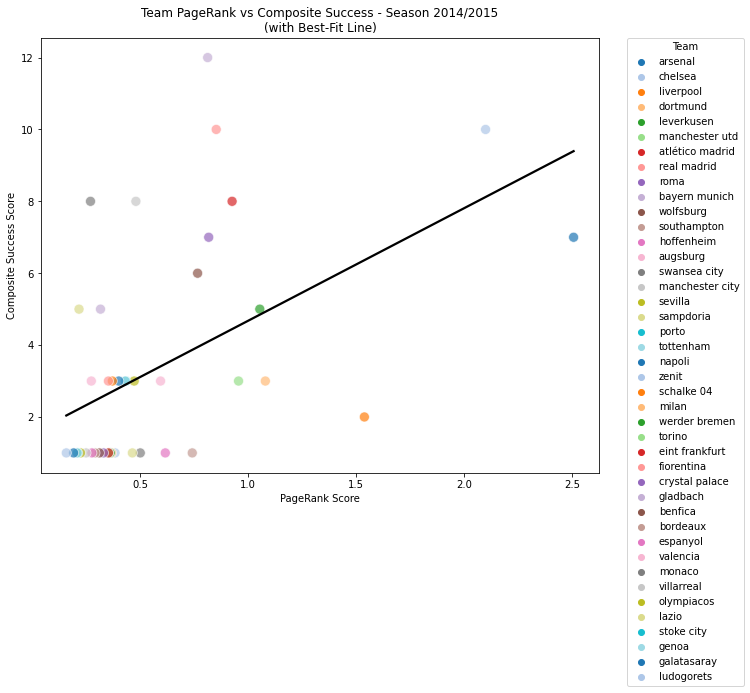

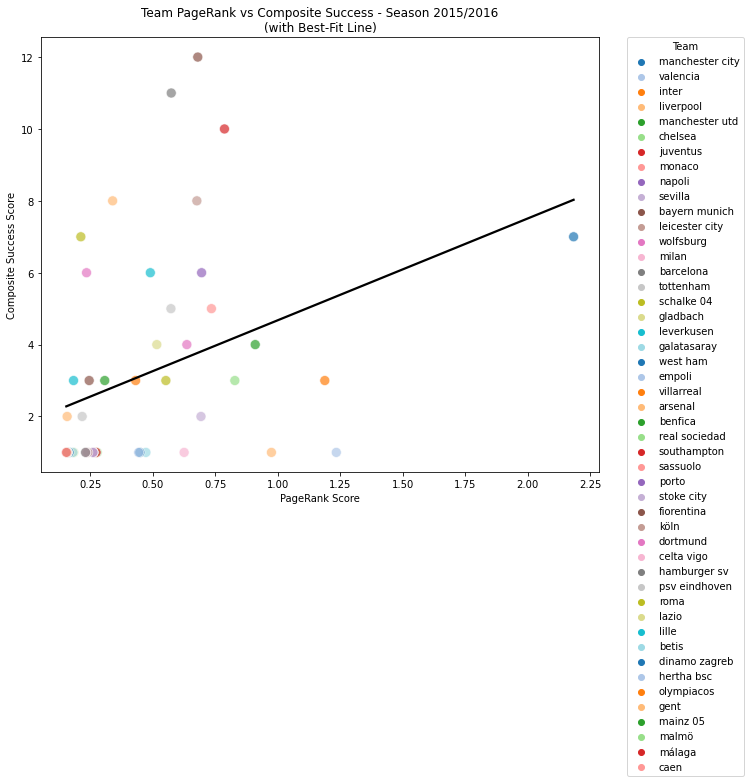

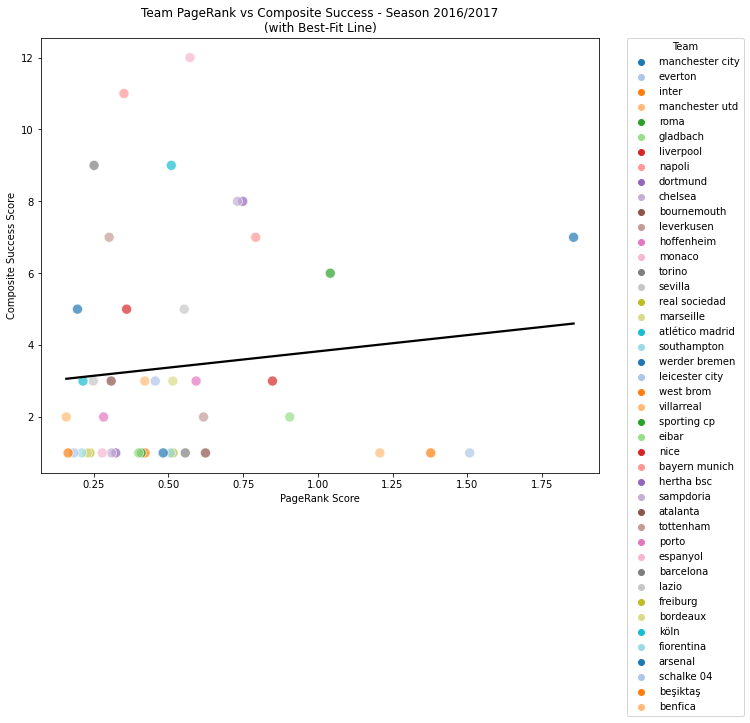

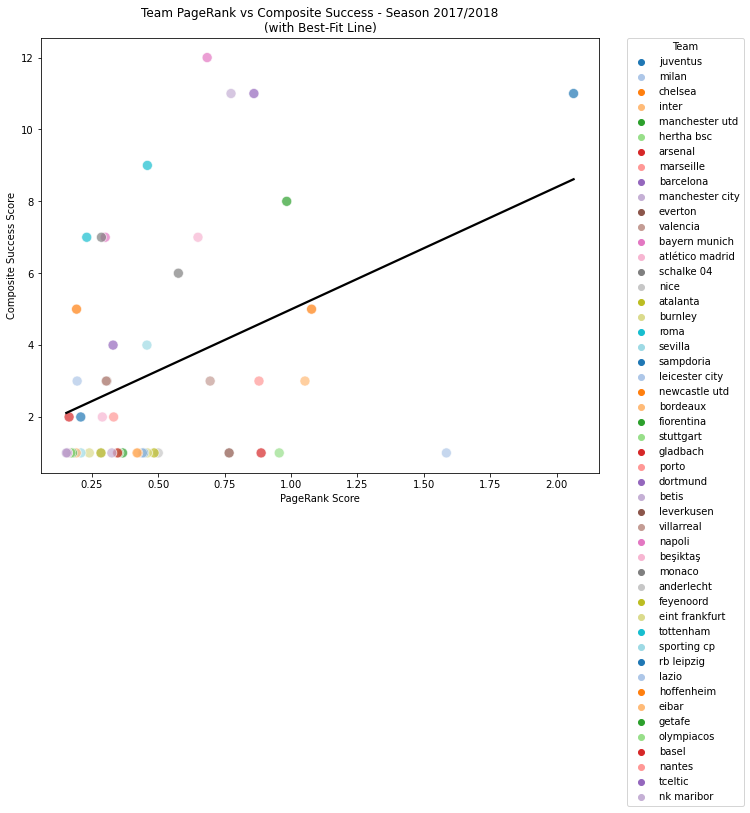

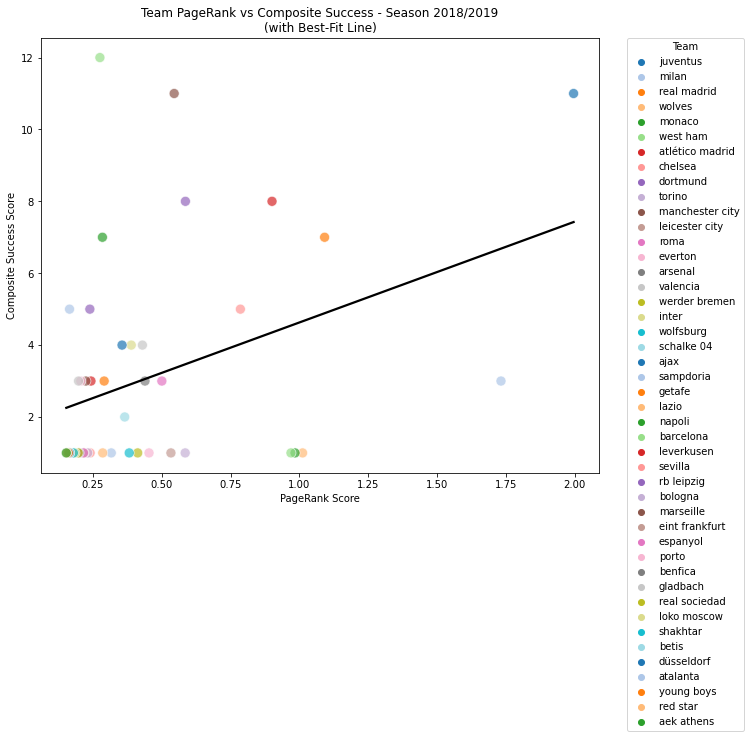

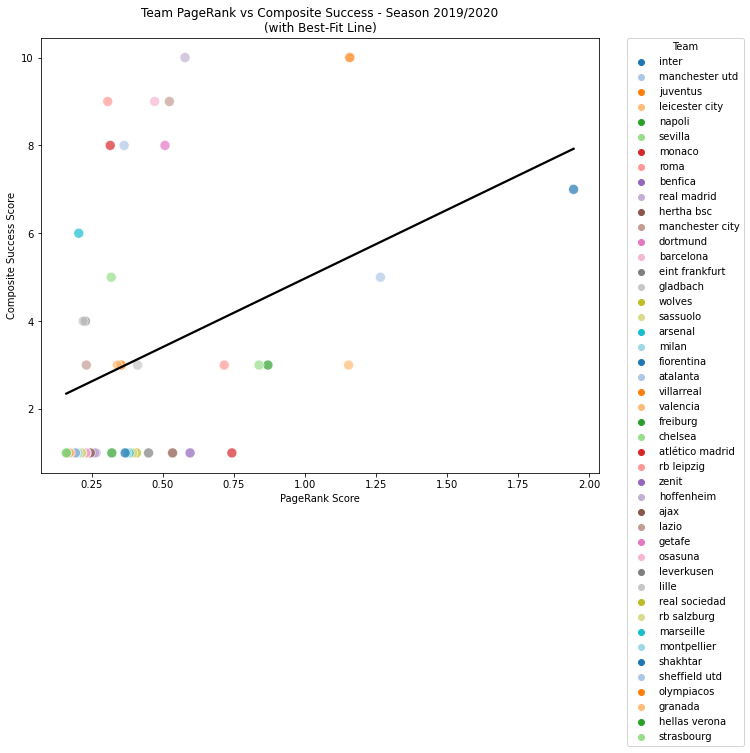

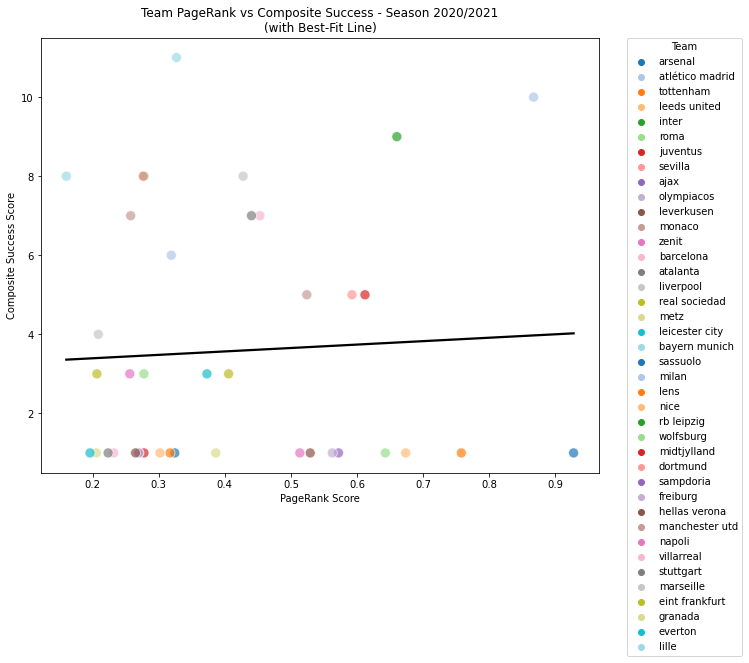

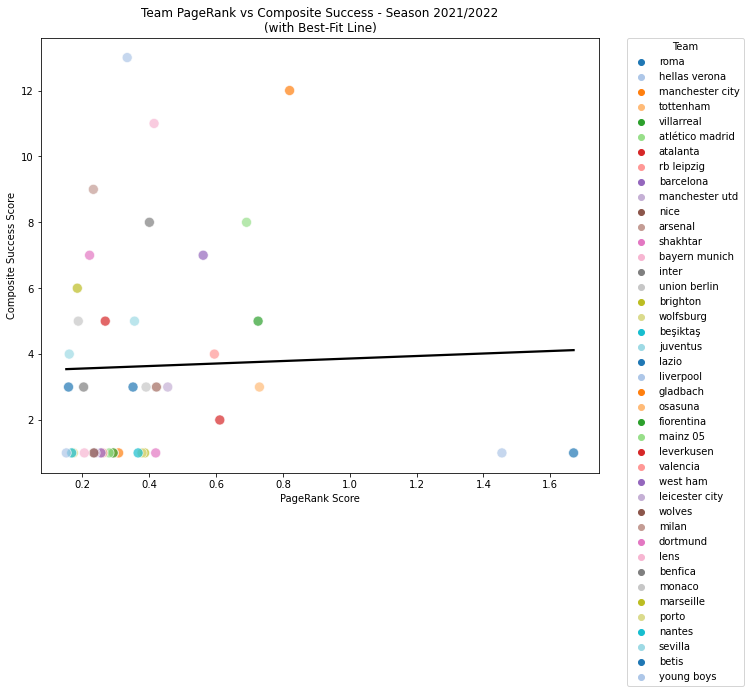

In [27]:
# PageRank vs Success Scatter Plot

# Get distinct seasons from the filtered data (ensure df_filtered is defined and filtered appropriately)
unique_seasons = df_filtered["season"].unique()

for season in unique_seasons:
    df_season = df_filtered[df_filtered["season"] == season]
    
    plt.figure(figsize=(10, 8))
    # Scatter plot: points colored by team
    sns.scatterplot(
        data=df_season, 
        x="pagerank", 
        y="compositeSuccess", 
        hue="club", 
        palette="tab20", 
        s=100, 
        alpha=0.7
    )
    # Overlay a best-fit regression line (black)
    sns.regplot(
        data=df_season, 
        x="pagerank", 
        y="compositeSuccess", 
        scatter=False, 
        color="black", 
        ci=None
    )
    plt.title(f"Team PageRank vs Composite Success - Season {season}\n(with Best-Fit Line)")
    plt.xlabel("PageRank Score")
    plt.ylabel("Composite Success Score")
    plt.legend(title="Team", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()


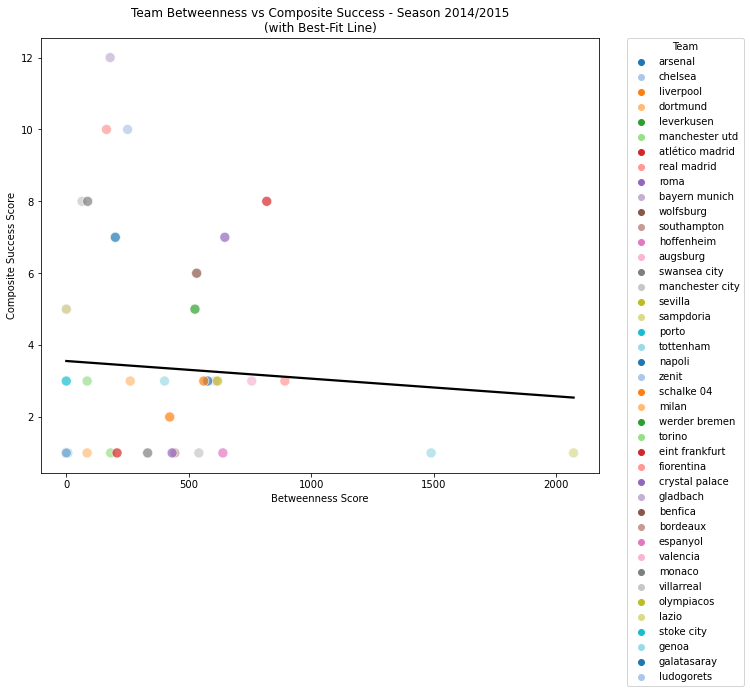

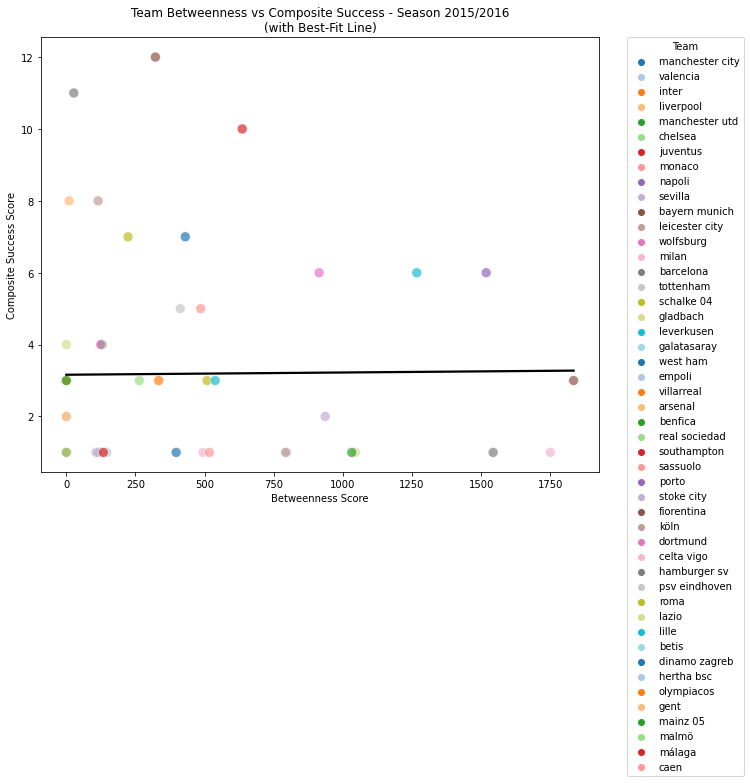

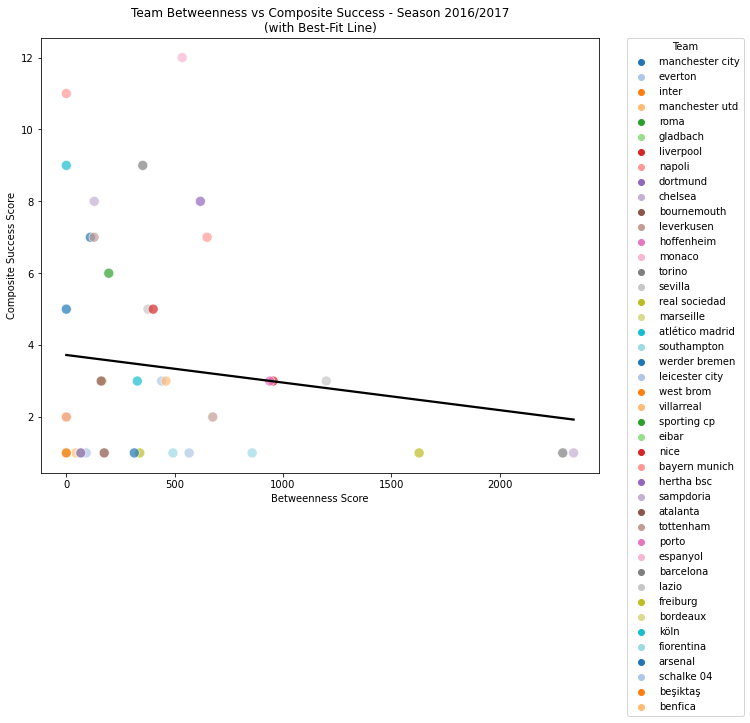

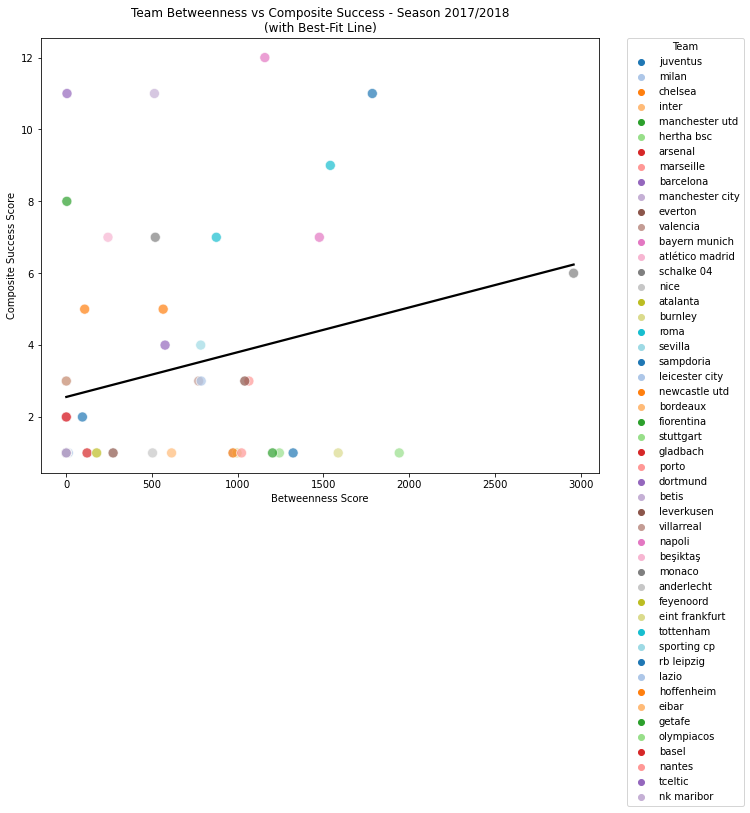

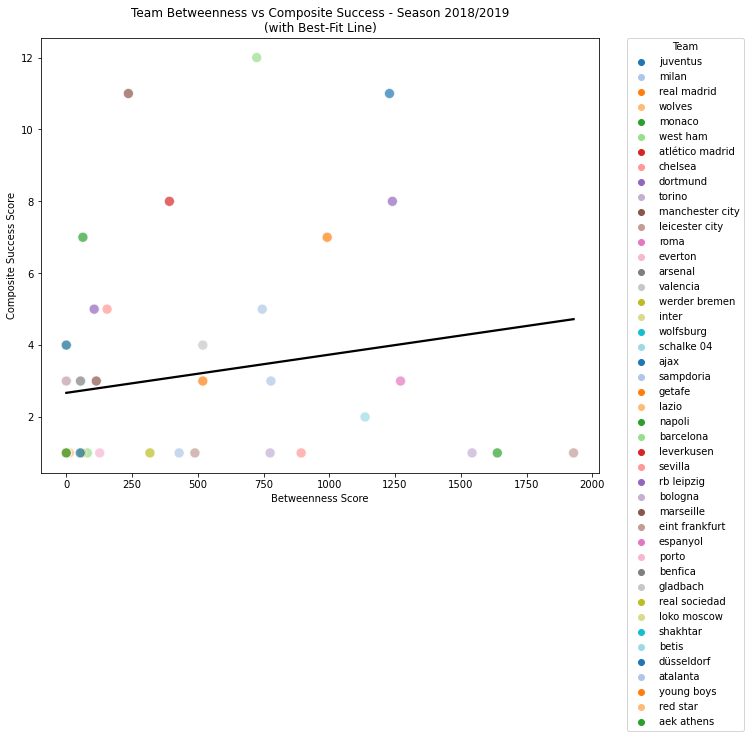

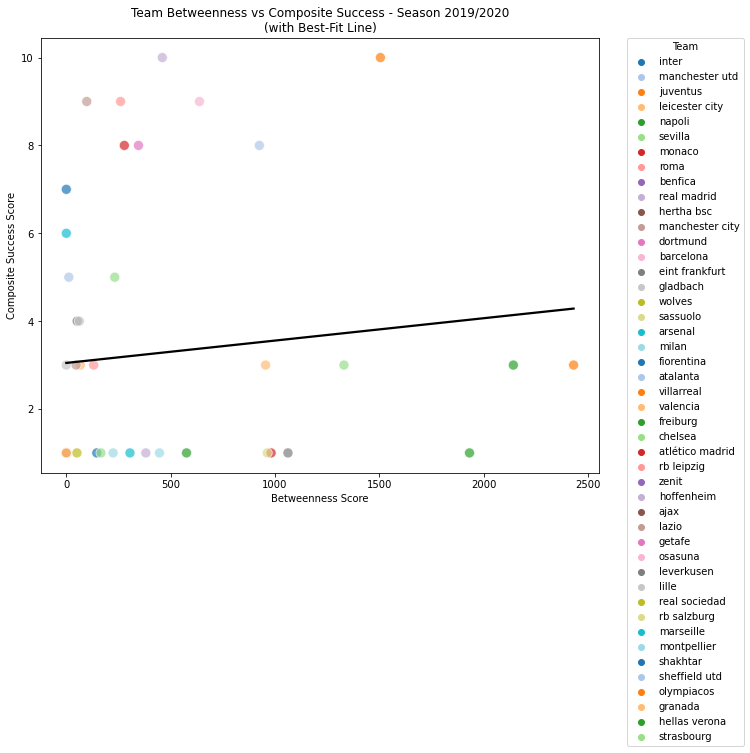

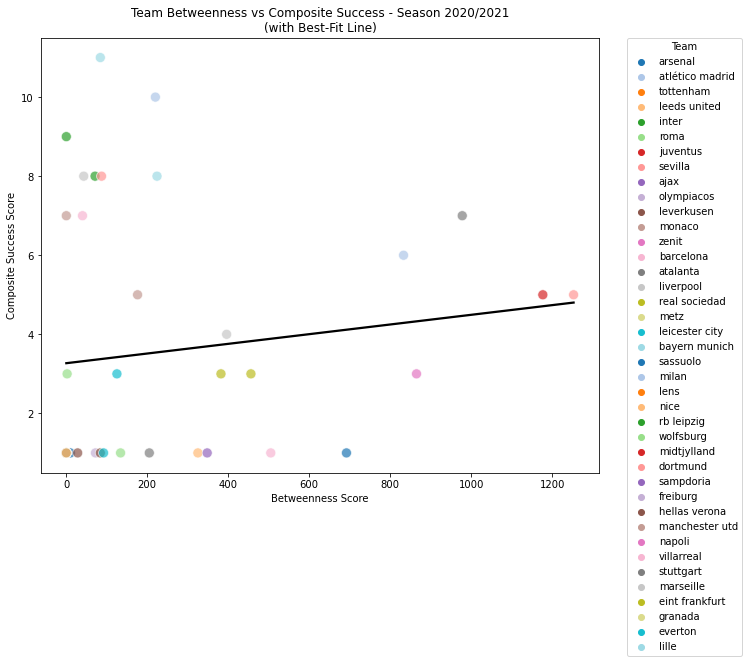

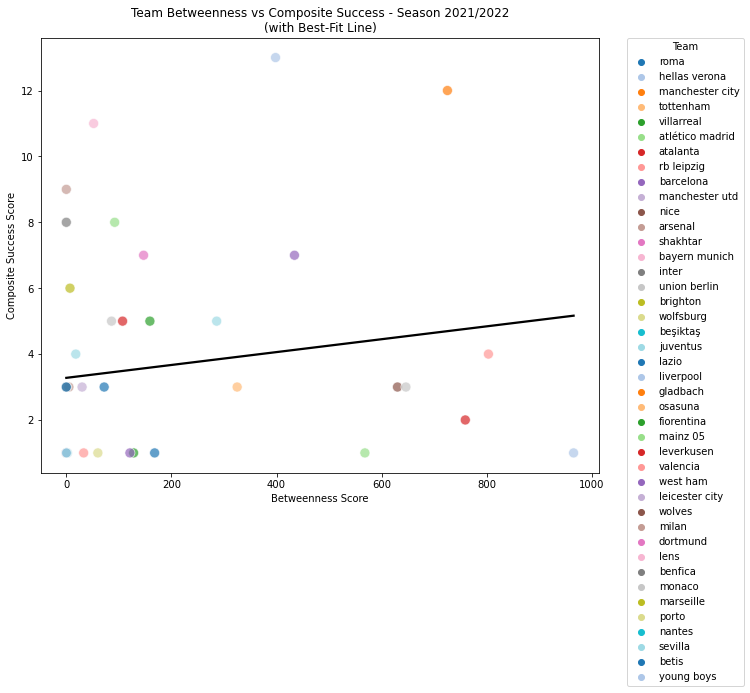

In [28]:
# Betweeness vs Success Scatter Plot

for season in unique_seasons:
    df_season = df_filtered[df_filtered["season"] == season]
    
    plt.figure(figsize=(10, 8))
    # Scatter plot: points colored by team
    sns.scatterplot(
        data=df_season, 
        x="betweenness", 
        y="compositeSuccess", 
        hue="club", 
        palette="tab20", 
        s=100, 
        alpha=0.7
    )
    # Overlay a best-fit regression line (black)
    sns.regplot(
        data=df_season, 
        x="betweenness", 
        y="compositeSuccess", 
        scatter=False, 
        color="black", 
        ci=None
    )
    plt.title(f"Team Betweenness vs Composite Success - Season {season}\n(with Best-Fit Line)")
    plt.xlabel("Betweenness Score")
    plt.ylabel("Composite Success Score")
    plt.legend(title="Team", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()


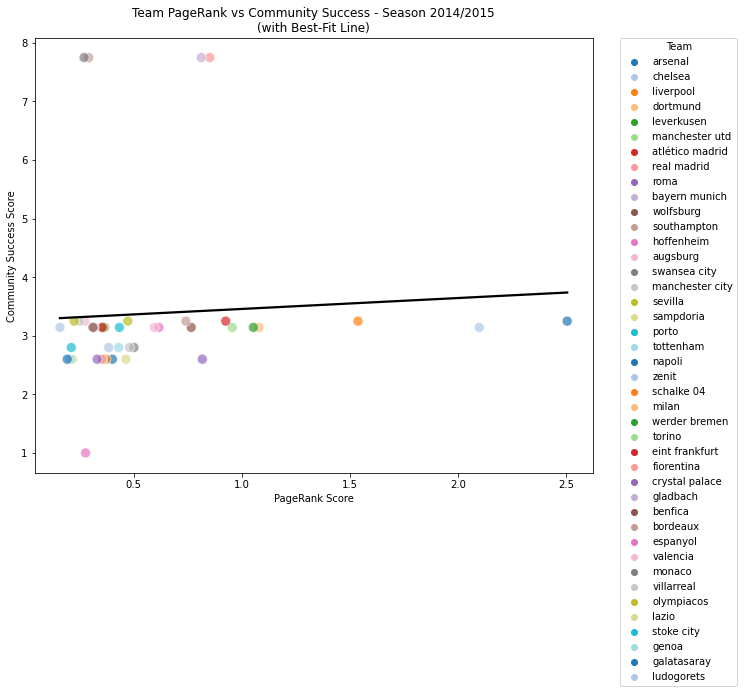

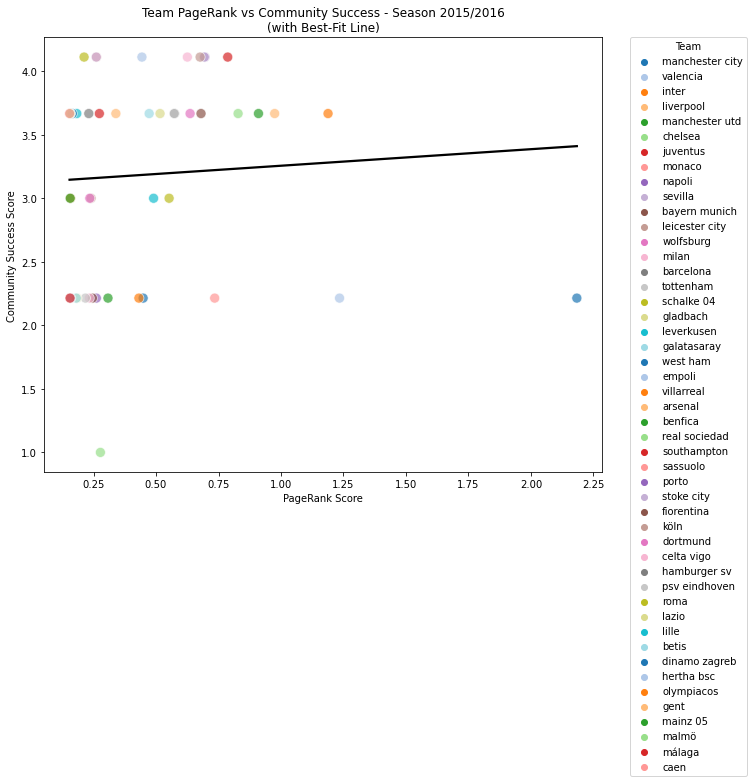

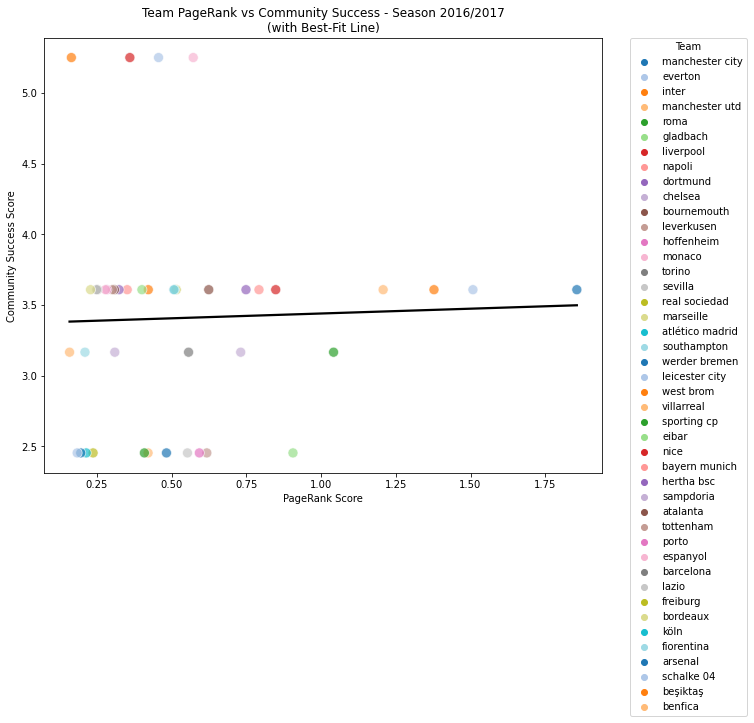

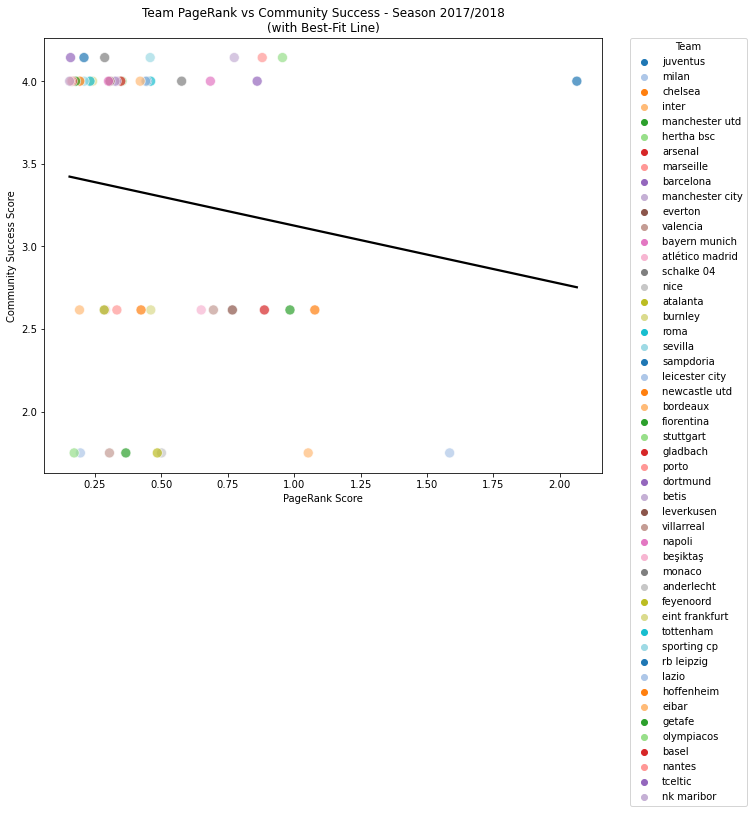

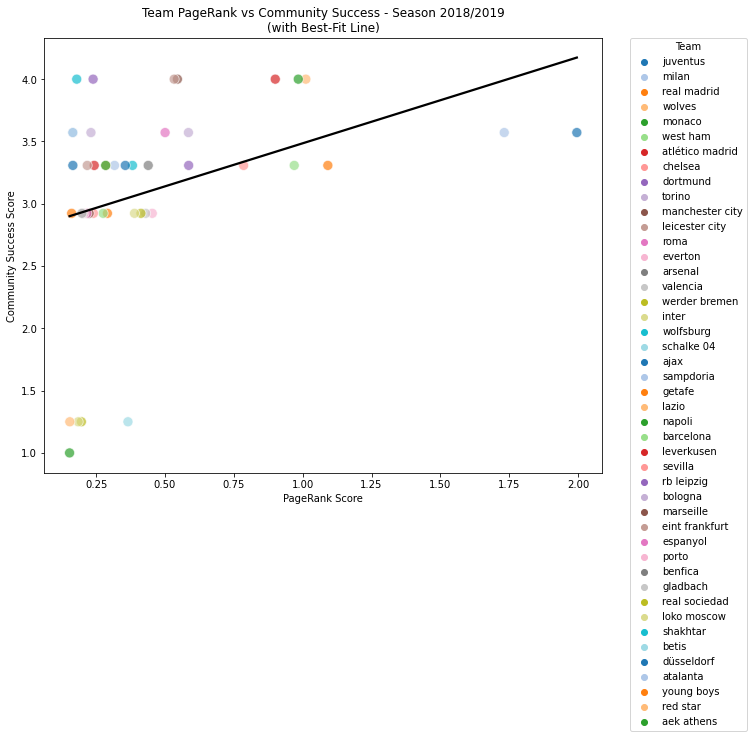

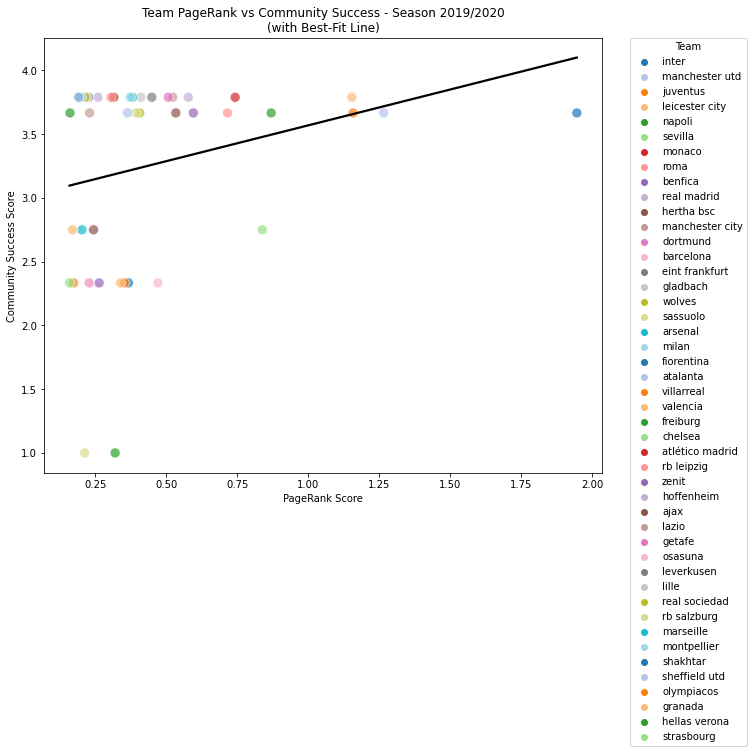

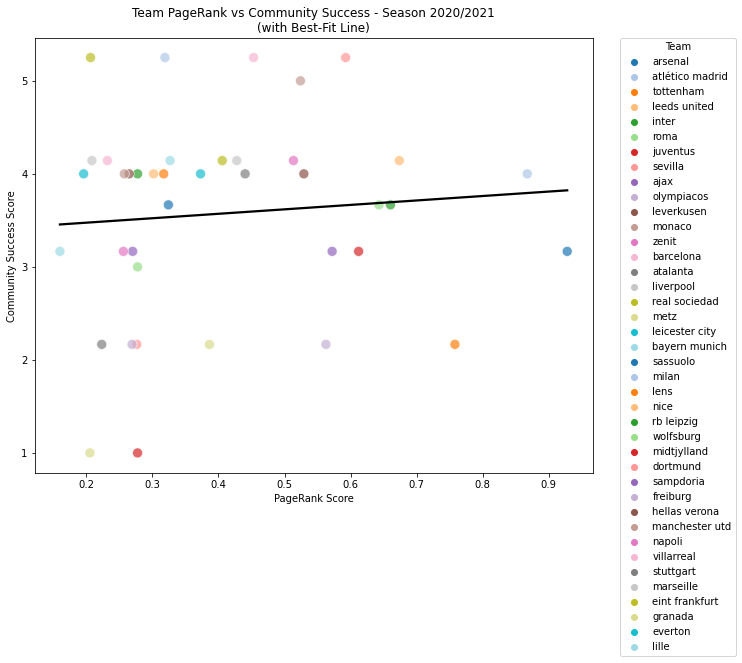

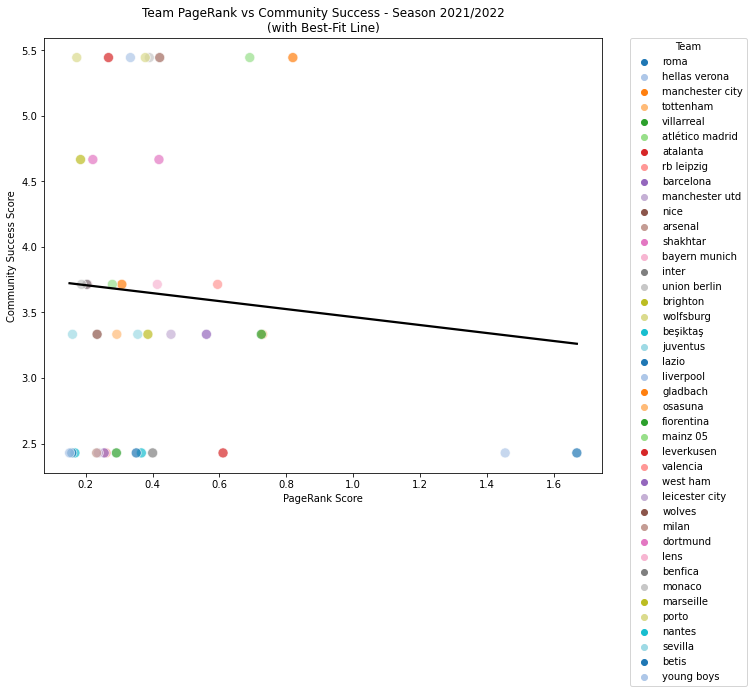

In [29]:
# Community Success vs PageRank Scatter Plot

# Get distinct seasons from the filtered data (df_filtered should already be defined and filtered appropriately)
unique_seasons = df_filtered["season"].unique()

for season in unique_seasons:
    # Get data for the current season and make a copy so we can add a new column
    df_season = df_filtered[df_filtered["season"] == season].copy()
    
    # Compute communitySuccess as the average compositeSuccess within each community and assign as a new column
    df_season["communitySuccess"] = df_season.groupby("community")["compositeSuccess"].transform("mean")
    
    # Create scatter plot for PageRank vs Community Success for this season
    plt.figure(figsize=(10, 8))
    ax = sns.scatterplot(
        data=df_season,
        x="pagerank",
        y="communitySuccess",
        hue="club",           # differentiate teams by color
        palette="tab20",      # use a palette with many distinct colors
        s=100,                # marker size
        alpha=0.7
    )
    
    # Overlay a best-fit regression line (black)
    sns.regplot(
        data=df_season,
        x="pagerank",
        y="communitySuccess",
        scatter=False,
        color="black",
        ci=None
    )
    
    plt.title(f"Team PageRank vs Community Success - Season {season}\n(with Best-Fit Line)")
    plt.xlabel("PageRank Score")
    plt.ylabel("Community Success Score")
    # Place legend outside to avoid overlapping with the plot
    plt.legend(title="Team", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()


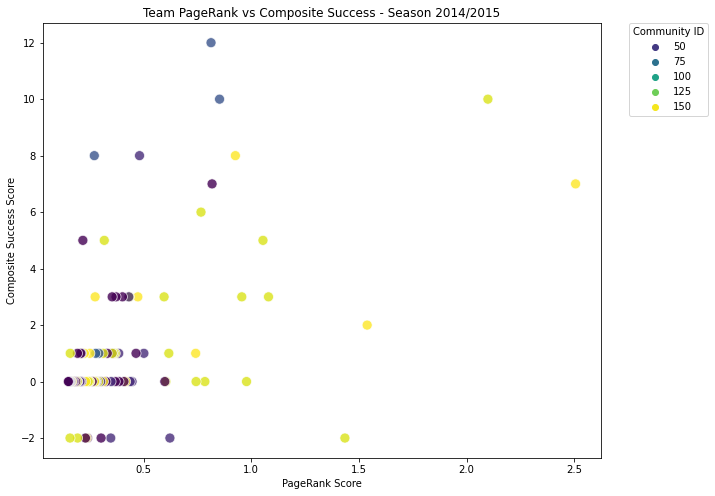

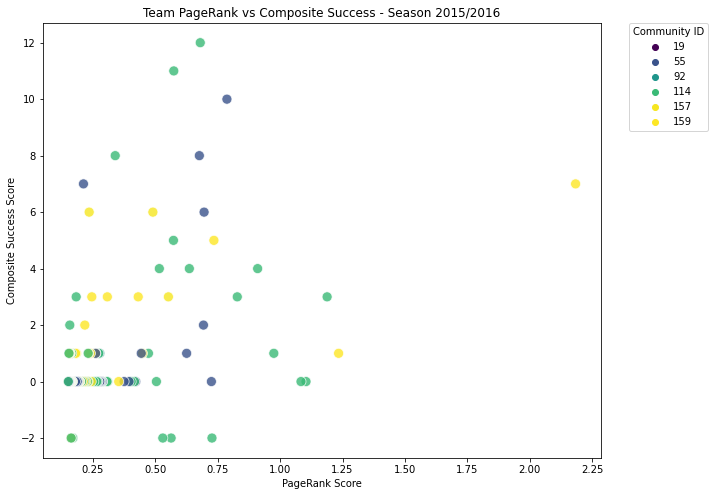

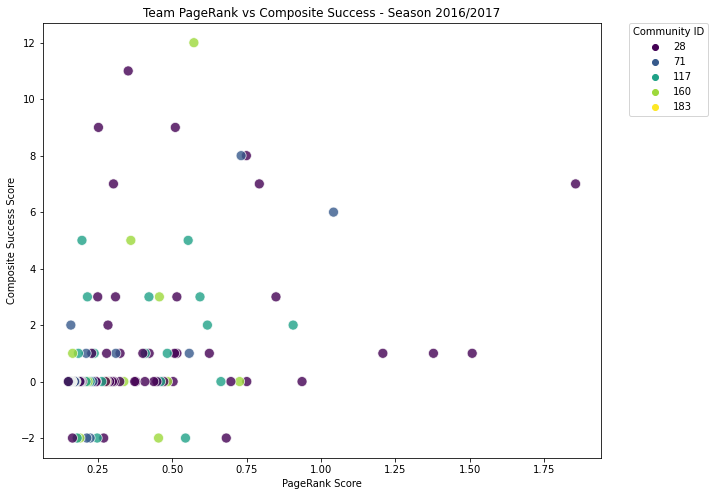

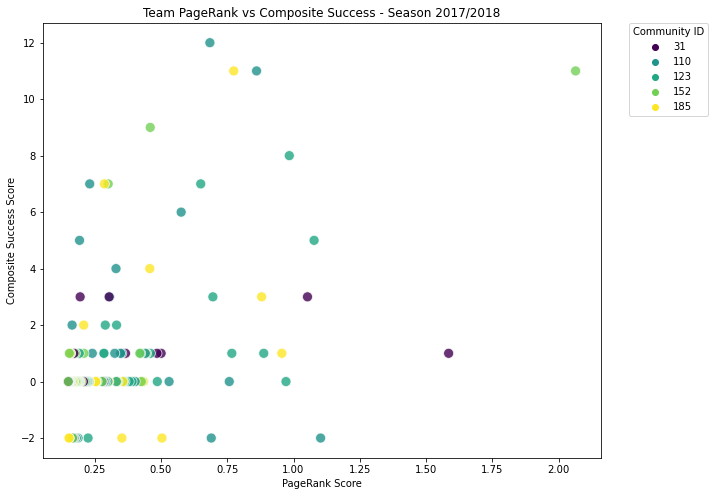

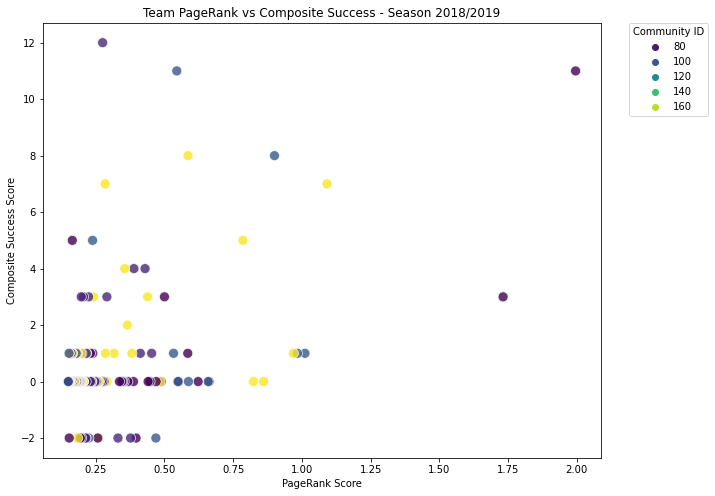

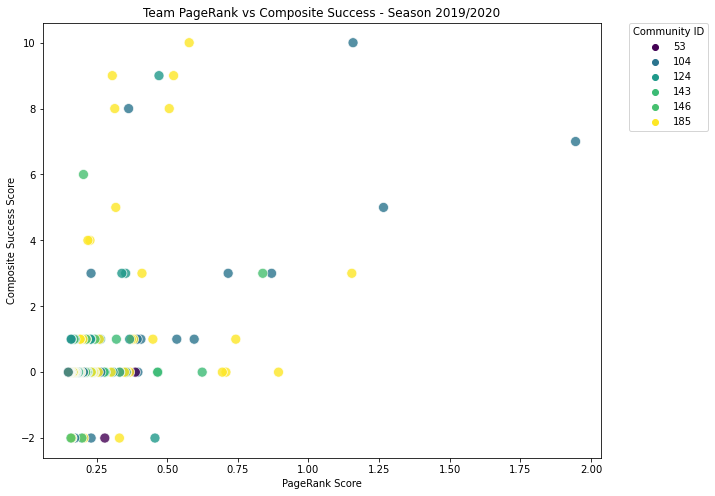

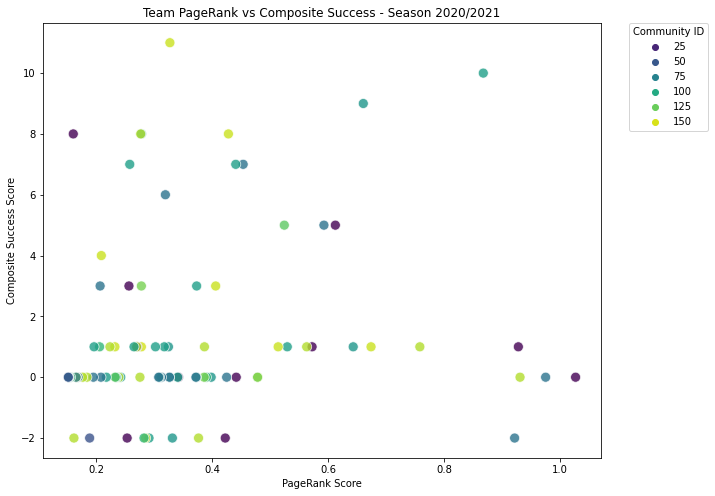

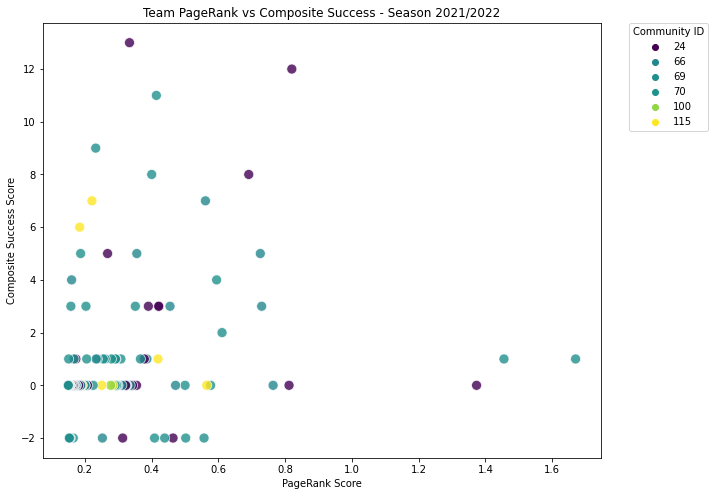

In [30]:
# Get unique seasons (only those with valid compositeSuccess values)
unique_seasons = sorted(df_merge[df_merge["compositeSuccess"].notna()]["season"].unique())

for season in unique_seasons:
    # Filter the merged data for the current season and exclude NaN compositeSuccess values
    df_season = df_merge[(df_merge["season"] == season) & (df_merge["compositeSuccess"].notna())].copy()
    
    # Create a scatter plot: PageRank (x-axis) vs Composite Success (y-axis), colored by community ID
    plt.figure(figsize=(10, 8))
    ax = sns.scatterplot(
        data=df_season,
        x="pagerank",
        y="compositeSuccess",
        hue="community",       # color by community ID
        palette="viridis",
        s=100,                 # marker size
        alpha=0.8
    )
    plt.title(f"Team PageRank vs Composite Success - Season {season}")
    plt.xlabel("PageRank Score")
    plt.ylabel("Composite Success Score")
    plt.legend(title="Community ID", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()


In [31]:
import pandas as pd
from IPython.core.display import HTML, display

# Optionally adjust Pandas display options
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 1000)

# Loop over each season and produce a community summary table sorted in descending order of avg composite success
for season in unique_seasons:
    # Filter the merged data for the current season and exclude rows with NaN compositeSuccess values
    df_season = df_merge[(df_merge["season"] == season) & (df_merge["compositeSuccess"].notna())].copy()
    
    # Calculate the average compositeSuccess per community
    community_summary = df_season.groupby("community").agg(
        avg_compositeSuccess=("compositeSuccess", "mean")
    ).reset_index()
    
    # Sort the summary in descending order (highest community success first)
    community_summary = community_summary.sort_values("avg_compositeSuccess", ascending=False)
    
    # Gather the list of teams (clubs) in each community, joining with HTML line break tags for proper rendering
    teams_by_comm = df_season.groupby("community")["club"].unique().reset_index()
    teams_by_comm["teams"] = teams_by_comm["club"].apply(lambda x: "<br>".join(sorted(list(x))))
    
    # Merge the summary with the teams list
    community_summary = pd.merge(community_summary, teams_by_comm[["community", "teams"]], on="community", how="left")
    
    print(f"Community Summary for Season {season} (sorted by avg composite success):")
    display(HTML(community_summary.to_html(escape=False)))


Community Summary for Season 2014/2015 (sorted by avg composite success):


,community,avg_compositeSuccess,teams
0,61,5.166667,bayern munichbordeauxlevantemaccabi tel avivmonacoreal madrid
1,152,1.600000,arsenalaston villaatlético madridbaşakşehirfeyenoordfulhamliverpoolmidtjyllandnewcastle utdolympiacosqprsevillasouthamptonvalenciavillarreal
2,145,1.357143,augsburgbenficabeşiktaşchelseadinamo zagrebdortmunddynamo kyiveint frankfurtevertonfreiburggladbachgreuther fürthhamburger svhertha bschoffenheimkölnleverkusenlorientludogoretsmainz 05manchester utdmilannott'ham forestpaderborn 07paris s-gportowerder bremenwolfsburg
3,65,1.000000,espanyol
4,44,0.769231,betisburnleycaenhull citymanchester citynorwich citypalermostoke citysunderlandswansea citytottenhamwest hamzenit
5,29,0.666667,atalantabolognabresciacagliaricardiff citycesenachievocrotonecrystal palacedüsseldorffc astanafiorentinagalatasaraygenoahannover 96hellas veronalazioleeds unitednapoliparmapescararb leipzigromasampdoriasassuoloschalke 04torinoudinesewatfordwest brom
6,100,0.000000,brentford


Community Summary for Season 2015/2016 (sorted by avg composite success):


,community,avg_compositeSuccess,teams
0,55,1.321429,atalantabeşiktaşbochumbolognabresciacesenacrotonecórdobaempolifreiburggenoahoffenheimjuventusleeds unitedleicester citylensmiddlesbroughmilanmontpelliernapolipalermoromasassuolosevillaspeziastoke citytorinounion berlin
1,157,1.285714,ajaxaugsburgdortmunddüsseldorfheidenheimingolstadt 04kölnleverkusenmainz 05olympiacosqprrb leipzigschalke 04werder bremen
2,159,1.260870,almeríaathletic clubbenficabetiscelta vigodarmstadt 98eibareint frankfurtespanyolfiorentinahertha bsclaziomanchester citymarseillemidtjyllandmonacomálagaportopsv eindhoventcelticvalenciavillarrealwest ham
3,114,1.038462,anderlechtarsenalaston villaauxerrebarcelonabayern munichbournemouthbrentfordburnleycaencagliarichelseaclub bruggecrystal palacedinamo zagrebevertonfulhamgalatasaraygentgladbachgreuther fürthhamburger svhannover 96hellas veronainterlas palmaslegia warsawlilleliverpoollorientluton townmalmömanchester utdnantesnewcastle utdnorwich citypaderborn 07paris s-gpescarasaint-étiennesampdoriasouthamptonsporting cpstuttgartsunderlandswansea citytottenhamudinesewatfordwest bromwolfsburgwolves
4,92,1.000000,real sociedad
5,19,0.000000,fc astana


Community Summary for Season 2016/2017 (sorted by avg composite success):


,community,avg_compositeSuccess,teams
0,28,1.45283,anderlechtatalantaatlético madridaugsburgbarcelonabayern munichbolognabordeauxbournemouthbrightoncaencagliaricarpichievocremonesecrystal palacedortmundeibarempoliespanyolevertonfulhamgalatasaraygenoahertha bschull cityinterlazioleeds unitedleganéslilleliverpoolmanchester citymanchester utdmarseillemálaganapolinewcastle utdnorwich cityportoreal sociedadsassuolosouthamptonstoke citystuttgartsunderlandswansea citytottenhamtoulousewatfordwest bromwest hamyoung boys
1,160,1.06250,angersaston villabetisbeşiktaşcesenadijongenkleicester cityloko moscowlorientmiddlesbroughmonaconicesaint-étiennevalenciawolves
2,71,0.93750,almeríabenficabragachelseacrotonefiorentinahellas veronalevantepalermopescararomasampdoriaspartak moscowtorinoudinesevenezia
3,117,0.84000,arsenalbaşakşehirclub bruggedarmstadt 98düsseldorfeint frankfurtferencvárosfreiburggentgladbachhamburger svhoffenheimingolstadt 04kölnleverkusenmainz 05olympiacosparis s-gschalke 04sevillasporting cpunion berlinvillarrealwerder bremenwolfsburg
4,183,0.00000,fc copenhagen


Community Summary for Season 2017/2018 (sorted by avg composite success):


,community,avg_compositeSuccess,teams
0,110,1.655172,almeríaaugsburgbarcelonabaselbayern munichbetisdarmstadt 98dortmunddüsseldorfeint frankfurtempolifc copenhagenfreiburggladbachhamburger svhoffenheimkölnlegia warsawleicester citylevanteleverkusenmainz 05metznantesschalke 04stuttgarttottenhamunion berlinwolfsburg
1,152,0.965517,amiensangersbeneventobordeauxbrentfordbresciacagliaricarpicesenachievofrosinonefulhamgetafehellas veronajuventuslillelorientnapolink mariborpalermopescararomasaint-étiennesalernitanasampdoriasassuolospalsporting cpudinese
2,123,0.937500,ajaxalavésanderlechtarsenalaston villaatlético madridbeşiktaşbournemouthbrightonburnleycelta vigochelseaeibarespanyolevertonfeyenoordhuddersfieldla coruñamanchester utdnewcastle utdnorwich citynott'ham forestparis s-gportoreal sociedadslavia praguestoke citysunderlandvalenciawatfordyoung boyszenit
3,31,0.857143,aek athensatalantacaencrotonefiorentinagenoainterlazioleganésmilanniceolympiacosspeziavillarreal
4,185,0.840000,athletic clubbolognacrystal palacedinamo zagrebgalatasaraygreuther fürthheidenheimhertha bschull citylas palmasleeds unitedmanchester citymarseillemiddlesbroughmonacorb leipzigred starsevillasouthamptonswansea citytceltictoulousewerder bremenwest bromwest ham


Community Summary for Season 2018/2019 (sorted by avg composite success):


,community,avg_compositeSuccess,teams
0,169,1.500000,ajaxarsenalathletic clubchelseacrotonecrystal palacedarmstadt 98dortmunddüsseldorfeint frankfurtfreiburggreuther fürthhannover 96hull citylazioleverkusennapolipaderborn 07parmareal madridsampdoriasouthamptonstuttgartunion berlinwest hamwolfsburg
1,100,1.142857,atlético madridbochumbrentfordbresciabrightonburnleyfulhamgenthuddersfieldleicester citymanchester citymonacorb leipzigrb salzburgshakhtarstoke citystrasbourgswansea cityvillarrealwest bromwolves
2,98,1.000000,aek athens
3,83,0.777778,alavésanderlechtangersantwerpaston villabarcelonabenficabournemouthcaencardiff citycelta vigoeibarespanyolevertonfc astanagetafegironagladbachguingampinterlas palmaslevantemarseillemetznantesnorwich citynott'ham forestportorayo vallecanosaint-étiennesevillavalenciavalladolidwatfordwerder bremenyoung boys
4,73,0.607143,atalantabaselbeneventobetisbolognacagliarichievocremonesedijonempolifiorentinafrosinonegenoahellas veronajuventusleccemilanpalermoromasalernitanasassuolospalspeziasporting cptorinotoulouseudinesevenezia
5,170,0.500000,fc copenhageningolstadt 04kölnloko moscownewcastle utdparis s-gpescarareal sociedadred starschalke 04
6,97,0.000000,dinamo zagreb


Community Summary for Season 2019/2020 (sorted by avg composite success):


,community,avg_compositeSuccess,teams
0,104,1.379310,atalantabeneventobenficacagliarichievoclub bruggecrystal palaceempoligenoahamburger svhellas veronahertha bscinterjuventuslaziomanchester utdmonzanapoliportoromasalernitanasampdoriasassuolospalspartak moscowspeziaudinesewatfordwolves
1,185,1.294118,amiensarsenalaston villaatlético madridauxerrebetisbochumbordeauxchelseacrotonecska moscowdarmstadt 98dijondortmundeint frankfurtevertonfulhamgladbachhoffenheimhuddersfieldhull citykölnleicester citylensleverkusenlillelorientmainz 05manchester citymidtjyllandmilanmonacomontpellierparis s-gpsv eindhovenrb leipzigreal madridreal sociedadschalke 04shakhtarsheffield utdsouthamptonsporting cpsporting gijóntceltictoulousetrangerstroyesveneziawerder bremenwest brom
2,146,1.000000,ajaxcaengironagranadaleganésmarseillenantesqarabağsevilla
3,124,0.826087,almeríabarcelonabeşiktaşbolognabrentfordcelta vigocremoneseeibarespanyolfiorentinagetafelevantenott'ham forestolympiacososasunaparmarayo vallecanostrasbourgtorinovalenciavalladolidvillarrealzenit
4,143,-0.181818,aek athensalavésanderlechtaugsburgdüsseldorffreiburggreuther fürthhannover 96heidenheimkrasnodarlegia warsawludogoretsmetznewcastle utdnorwich citypaderborn 07rb salzburgsaint-étiennestuttgartunion berlinwest hamyoung boys
5,53,-1.000000,frosinonelecce


Community Summary for Season 2020/2021 (sorted by avg composite success):


,community,avg_compositeSuccess,teams
0,147,3.375000,bayern munichhuescaleeds unitedliverpoolmarseillereal sociedadvillarrealzenit
1,121,2.500000,mallorcamonaco
2,93,2.375000,atalantaatlético madridcrotoneevertonhellas veronalecceleicester citylensleverkusenmanchester utdnicenorwich cityrb leipzigreimsspaludinese
3,9,1.363636,ajaxarsenalaston villaathletic clubjuventuslillenapoliparmasampdoriatorinowerder bremen
4,66,1.357143,almeríabarcelonaclub bruggecádizeint frankfurtespanyolgetafehertha bsckölnleganésmilanosasunaparis s-gsevilla
5,88,1.285714,beneventocagliarifiorentinagenoainterromasassuolo
6,128,1.000000,augsburgpsv eindhovenwolfsburg
7,149,1.000000,midtjylland
8,142,0.642857,amiensbenficadortmundfreiburgfulhamheidenheimhoffenheimmetzolympiacossouthamptonstrasbourgstuttgarttottenhamvalladolid
9,34,0.000000,pescara


Community Summary for Season 2021/2022 (sorted by avg composite success):


,community,avg_compositeSuccess,teams
0,24,1.730769,antwerparsenalaston villaatlético madridbolognaburnleyclub bruggedüsseldorfeint frankfurtevertonfulhamleverkusenliverpoolloko moscowmanchester citynewcastle utdnicenorwich cityparmaportoschalke 04southamptonswansea cityunion berlinwerder bremenwolfsburg
1,115,1.400000,anderlechtcesenadortmundempolimarseillemonzasassuoloshakhtarspalspezia
2,66,1.333333,almeríaangersbarcelonabragabrightoneibarespanyolgetafejuventusleeds unitedlevantemallorcamanchester utdosasunasampdoriasevillatceltictottenhamtoulousevillarrealwolves
3,69,0.923077,atalantabaşakşehirbetisbeşiktaşbordeauxcagliarifiorentinagenoagranadahellas veronainterlazioleicester cityludogoretsmilannantesnott'ham forestpescararomaspartak moscowstoke cityudinesevalenciawatfordwest hamyoung boys
4,70,0.909091,aek athensbayern munichbenficacrystal palacecádizelchegladbachgreuther fürthhertha bscingolstadt 04krasnodarleccelensmainz 05monaconk mariborolympiacosrb leipzigslavia praguestuttgarttroyesvenezia
5,100,0.000000,brentford


Seasons after filtering:
['2015/2016' '2016/2017' '2017/2018' '2018/2019' '2019/2020' '2020/2021'
 '2021/2022']


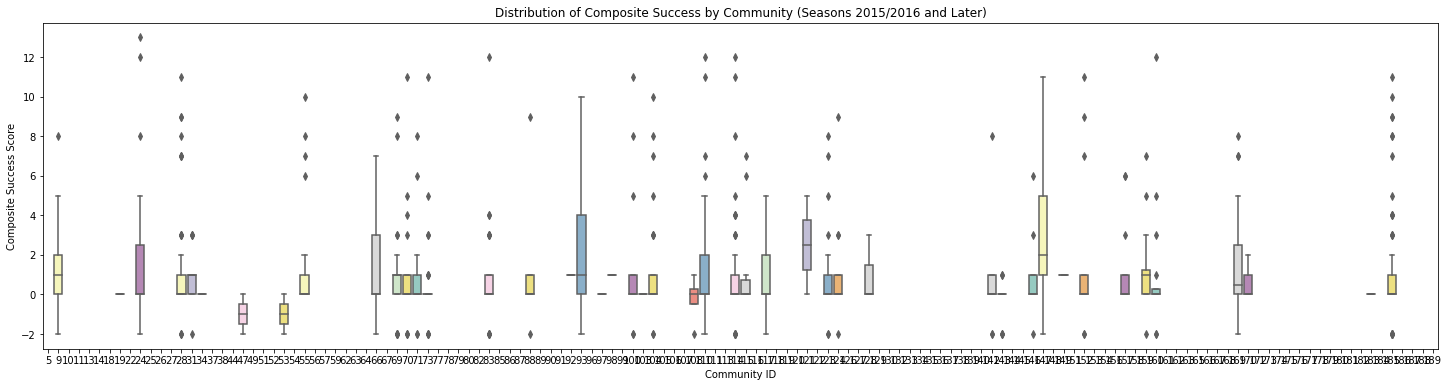

In [32]:
# Filter for seasons starting from 2015/2016 onward
df_recent = df_merge[df_merge["season"].apply(lambda s: int(s.split('/')[0]) >= 2015)]

# Verify the filtering by printing unique seasons
print("Seasons after filtering:")
print(df_recent["season"].unique())

# Create a box plot for composite success by community using the filtered data
plt.figure(figsize=(25, 6))
sns.boxplot(x="community", y="compositeSuccess", data=df_recent, palette="Set3")
plt.title("Distribution of Composite Success by Community (Seasons 2015/2016 and Later)")
plt.xlabel("Community ID")
plt.ylabel("Composite Success Score")
plt.show()


In [33]:
session.close()
driver.close()

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL gds.graph.drop('clubTransferGraph_2021_2022')"
